**Required Packages**

In [ ]:
#As we dont have any GPU we will be using google collab for GPU usage
#Mount at drive 
import sys
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#needed packages to install
#!pip install texthero==1.0.5
!pip install gensim
!pip install openpyxl 
!pip install bnlp_toolkit
!pip install python-bidi
!pip install texthero
!pip install bangla-stemmer

     |████████████████████████████████| 1.2MB 7.9MB/s 
     |████████████████████████████████| 23.9MB 125kB/s 
     |████████████████████████████████| 747kB 31.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.5MB 7.5MB/s 
     |████████████████████████████████| 245kB 50.2MB/s 
     |████████████████████████████████| 24.2MB 118kB/s 
ERROR: bnlp-toolkit 3.1.1 has requirement gensim==4.0.1, but you'll have gensim 3.8.3 which is incompatible.
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
  Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1


In [ ]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
from bnlp.corpus import stopwords, punctuations
import bnlp
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from bnlp import BasicTokenizer,NLTKTokenizer
from bangla_stemmer.stemmer.stemmer import BanglaStemmer
import warnings
warnings.filterwarnings("ignore")

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Data Cleaning**

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/dataset/multi class bangla social media comment.xlsx')
df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/dataset/multi_class_bangla_social_media_comment.csv', encoding='utf-8', index=False)

df_plot=df.copy()
df.head()

,comment,Category,Gender,comment react number,label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Actor,Female,1.0,sexual
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully
4,পটকা মাছ,Politician,Male,0.0,troll


In [ ]:
df = df.rename(columns={'comment react number': 'comment_react_number'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44001 entries, 0 to 44000
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comment               44001 non-null  object 
 1   Category              44001 non-null  object 
 2   Gender                44001 non-null  object 
 3   comment_react_number  43998 non-null  float64
 4   label                 44001 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
#Details of each column

Category_counts=df.Category.value_counts()
Gender_counts=df.Gender.value_counts()
Comment_react_counts=df.comment_react_number.value_counts()
label_counts=df.label.value_counts()
print(Category_counts)
print("\n",Gender_counts)
print("\n",Comment_react_counts)
print("\n",label_counts)

Actor         26951
Social         9375
Singer         2981
Politician     2633
Sports         2061
Name: Category, dtype: int64

 Female    29950
Male      14051
Name: Gender, dtype: int64

 0.0      28725
1.0       8193
2.0       2955
3.0       1326
4.0        711
         ...  
60.0         1
67.0         1
132.0        1
149.0        1
284.0        1
Name: comment_react_number, Length: 114, dtype: int64

 not bully    15340
troll        10462
sexual        8928
religious     7577
threat        1694
Name: label, dtype: int64


In [ ]:
df_abuse = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/dataset/new datasets/finaldata.csv', encoding='utf-8')
df_abuse.head()
df_abuse.label.value_counts()


Political    12874
sexual        3134
religious     1459
Name: label, dtype: int64

In [ ]:
col=['comment_react_number','Category','Gender']
df=df.drop(col,axis=1)
df.label.value_counts()
df.head()

,comment,label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,sexual
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,not bully
2,"অরে বাবা, এই টা কোন পাগল????",not bully
3,ক্যাপ্টেন অফ বাংলাদেশ,not bully
4,পটকা মাছ,troll


In [ ]:
df_abuse = df_abuse.rename(columns={'text': 'comment'})
df_abuse.head()

,comment,label,target
0,ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...,Political,NaN
1,রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে,Political,NaN
2,এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...,religious,NaN
3,আমরা বলতে কারা ভারত তাইতো,Political,NaN
4,পাকিস্তান আমার বাল,Political,NaN


In [ ]:
#df_abuse = df_abuse.rename(columns={'text': 'comment'})
df_abuse=df_abuse.drop(['target'],axis=1)
df_abuse.label.value_counts()

Political    12874
sexual        3134
religious     1459
Name: label, dtype: int64

In [ ]:
df_full=df.append(df_abuse)
df_full.label.value_counts()

not bully    15340
Political    12874
sexual       12062
troll        10462
religious     9036
threat        1694
Name: label, dtype: int64

In [ ]:
#df_fake_sexual=df_full.loc[df_full.label == 'sexual'][:11000]
#df_fake_political=df_full.loc[df_full.label == 'Political'][:11000]
#df_religious=df_full.loc[df_full.label == 'religious']
#df_religious=df_religious.append([df_fake_political,df_fake_sexual])
#df_religious=df_religious.replace({'label': {"Political":"religious"}})
#df_religious.label.value_counts()

In [ ]:
df_political=df_full.loc[df_full.label == 'Political'][:11000]
df_sexual=df_full.loc[df_full.label == 'sexual'][:11000]
df_not_bully=df_full.loc[df_full.label == 'not bully'][:11000]
df_religious=df_full.loc[df_full.label == 'religious']



In [ ]:
df_political.label.value_counts()

Political    11000
Name: label, dtype: int64

In [ ]:
#table
df=df_not_bully.append([df_religious,df_political,df_sexual])
df.label.value_counts()

Political    11000
not bully    11000
sexual       11000
religious     9036
Name: label, dtype: int64

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df=df.reset_index(drop=True)
df.head()

,comment,label
0,ছালা পাকিস্তানীদের জন্য বাশ দিয়া দাও ভর দিয়া হ...,Political
1,"ফ্যামিলিটাই তো নাস্তিক,,,এর থকে বেশি আশা করা য...",religious
2,তুই মাগি তোর কোন মাফ নাই তুই বলে আখিরাত বিশ্বা...,sexual
3,"সাফা কবির , আমি তোর ১জন কঠিনফ্যান ছিলাম। আজ থে...",religious
4,সুপার সুপার হিরো,not bully


In [ ]:
df_copy=df.copy()

In [ ]:
#preprocessing

def demoji(text):
	emoji_pattern = re.compile("["
		u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U00010000-\U0010ffff"
	                           "]+", flags=re.UNICODE)
	return(emoji_pattern.sub(r'', text)) 


def clean(text):
    text = re.sub('[%s]' % re.escape(punctuations), ' ', text)     #escape punctuation
    text = re.sub('\n', ' ', text)                                 #replace line break with space
    text = re.sub('\w*\d\w*', ' ', text)                           #ignore digits
    #text = re.sub('\xa0', ' ', text)                              
    return text

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[\u09E6-\u09FF]+', ' ', text)                  #remove bangla punctuations
    return text




In [ ]:
df[u'text'] = df[u'comment'].astype(str)
df[u'text'] = df[u'text'].apply(lambda x:demoji(x))
df['text'] = df['text'].apply(lambda x: re.split('http:\/\/.*', str(x))) #remove urls
df["text"] = df['text'].apply(lambda x: clean(str(x)))                      
df['text'] = df['text'].apply(lambda x: remove_punct(x))

In [ ]:
#remove special characters
spec_chars = ["!",'"',"।","#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['text'] = df['text'].str.replace(char, ' ') 
    df['text'] = df['text'].str.split().str.join(' ')         #remove whitespace


In [ ]:
#checking......
df.text[2226]

'সব মালাত'

In [ ]:
#remove bangla stopwords

custom_stop_word_list=['আমার ','অথচ ','অথবা ','অনুযায়ী ','অনেক ','অনেকে ','অনেকেই ','অন্তত ','অন্য ','অবধি ','অবশ্য ','অর্থাত ','আই ','আগামী ','আগে ','আগেই ','আছে ','আজ ','আদ্যভাগে ',
                       'আপনার ','আপনারা ','আপনি ','আবার ','আসবে ','আমরা ',' আমাকে ','আমাদের ','আমার ','আমি ','আর ','আরও ','ইত্যাদি ','ইহা ','উচিত ','উত্তর ','উনি ','উপর ','উপরে ','এ ','এঁদের ','এঁরা ','এরা ',
                       'এই ','একই ','একটি ','একবার ','একে ','এক্ ','এখন ','এখনও ','এখানে ','এখানেই ','এটা ','এটাই ','এটি ','এত ','এতটাই ','এতে ','এদের ','এব ','এবং ','এবার ','এমন ','এমনকী ',
                       'এমনি ','এর ','এরা ','এল ','এস ','এসে ','ঐ ','ওঁদের ','ওঁর ','ওঁরা ','ওই ','ওকে ','ওখানে ','ওদের ','ওর ','ওরা ','কখনও ','কত ','কবে ','কমনে ','কয়েক ','কয়েকটি ','করছে ',
                       'করছেন ','করতে ',' করবে',' করবেন',' করলে ',' করলেন',' করা',' করাই',' করায়',' করার',' করি','করতে ','করিতে ','করিয়া ','করিয়ে ','করে ','করেই ','করেছিলেন ','করেছে ','করেছেন ','করেন ',
                       'কাউকে ','কাছ ','কাছে ','কাজ ','কাজে ','কারও ','কারণ ','কি ','কিংবা ','কিছু ','কিছুই ','হেতি ','কিন্তু ','ন্তু ','কী ','কে ','কেউ ','কেউই ','কেখা ','কেন ','কোটি ','কোন ','কোনও ',
                       'কোনো ','ক্ষেত্রে ','কয়েক ','খুব ','গিয়ে ','গিয়েছে ','গেছেন ','গিয়ে ','গুলি ','গেছে ','গেল ','গেলে ','গোটা ','চলে ','চান ','চায় ','চার ','চালু ','চেয়ে ','চেষ্টা ','ছাড়া ','ছাড়াও ','ছিল ','ছিলেন ','জন ',
                       'জনকে ','জনের ','জন্য ','জন্যওজে ','জানতে ','জানা ','জানানো ','জানায় ','জানিয়ে ','জানিয়েছে ','জ্নজন ','জন ','টা ','টি ','ঠিক ','তখন ','তত ','তথা ','তবু ','তবে ','তা ','তাঁকে ','তাঁদের ',
                       'তাঁর ','তোর ','তাঁরা ','তাঁহারা ','তাই ','যে ''তাও ','তাকে ','তাতে ','তাদের ','তার ','তারপর ','তারা ','তারৈ ','তাহলে ','তাহা ','তাহাতে ' ,'তাহার ','তিনঐ ','তিনি ','তিনিও ','তুমি ','তুলে ','তেমন ','তো ','তোমার ',
                       'থাকবে ','থাকবেন ','থাকা ','থাকায় ','থাকে ','থাকেন ','থেকে ','থেকেই ','থেকেও ','দিকে ','দিতে ','দিতাম','দিন ','দিয়ে ','দিয়েছে ','দিয়েছেন ','দিলেন ', 'দু ','দুই ','দুটি ','দুটো ','দেওয়া ','দেওয়ার ','দেওয়া ',
                       'দেখতে ','দেখা ','দেখে ','দেন ','দেয়া ','দেয় ','দ্বারা ','ধরা ','ধরে ','ধামার ','নতুন ','নাই ','নাকি ','নাগাদ ','নানা ','নিজে ','নিজেই ','নিজেদের ','নিজের ','নিতে ','নিয়ে ','নিয়ে ','নেই ','নেওয়া ','নেওয়ার ',
                       'নেওয়া ','নয় ','পক্ষে ','পর ','পরে ','পরেই ','পরেও ','পর্যন্ত ','পাওয়া ','পাচ ','পারি ','পারে ','পারেন ','পেয়ে ','পেয়্র্ ','প্রতি ','প্রথম ','প্রভৃতি ','প্রযন্ত ','প্রাথমিক ','প্রায় ','প্রায় ','ফলে ','ফিরে ','ফের ',
                       'বক্তব্য ','বদলে ','বন ','বরং ','বলতে ','বলছি ','বলল ','বললেন ','বলা ','বলে ','বলেছেন ','বলেন ','বসে ','বহু' ,'বাদে ','বার ','বিনা ','বিভিন্ন ','বিশেষ ','বিষয়টি ','বেশ ','বেশি ','ব্যবহার ','ব্যাপারে ','ভাবে ', 'ভাবেই ',
                       'মতো ','মতোই ','মধ্যভাগে ','মধ্যে ','মধ্যেই ','মধ্যেও ','মনে ','মাত্র ','মাধ্যমে ','মোট ','মোটেই ','যখন ','যত ','যতটা ','যথেষ্ট ','যদি ','যদিও ','যা ','যাঁর ','যাঁরা ','যাওয়া ','যাওয়ার ','যাওয়া ','যাকে ','যাচ্ছে ',
                       'যাতে ','যাদের ','যান ','যাবে ','যায় ','যার ','যারা ','যিনি ','অতএব ','যেখানে ','যেতে ','যেন ','যেমন ','রকম ','রয়েছে ','রাখা ','রেখে ','লক্ষ ','শুধু ','শুরু ','সঙ্গে ','সঙ্গেও ','সব ','সবার ','সবাইর ','সমস্ত ',
                       'সম্প্রতি ','সহ ','সহিত ','সবই ','সাধারণ ','সামনে ','সুতরাং ','সবাইর ','সে ','সেই ','সেখান ','সেখানে ','সেটা ', 'সেটাই ','সেটাও ','সেটি ','স্পষ্ট ','স্বয়ং ','হইতে ','হইবে ','হইয়া ','হওয়া ','হওয়ায় ','হওয়ার ','হচ্ছে ','হত ','হতে ',
                       'লেগেছে ','হতেই ','হন ','হইত ','হবে ','তিনি ','হবেন ','হয় ','হয়তো ','হয়নি ','হয়ে ','হয়েই ','হয়েছিল ','হয়েছে ','হয়েছেন ','হল ','হলে ','হলেই ','হলেও ','হলো ','হাজার ','হিসাবে ','হৈলে ','হোক ','হয় ']

#digits=['০ ','১ ','২ ','৩ ','৪ ','৫ ','৬ ','৭ ','৮ ','৯ ']

final_stopword_list = custom_stop_word_list 

pat = r'\b(?:{})\b'.format('|'.join(final_stopword_list))
df['text'] = df['text'].str.replace(pat, ' ')
df['text'] = df['text'].str.replace(r'\s+', ' ')


In [ ]:
#checking......
df.text[2226]

' মালাত'

(-0.5, 399.5, 199.5, -0.5)

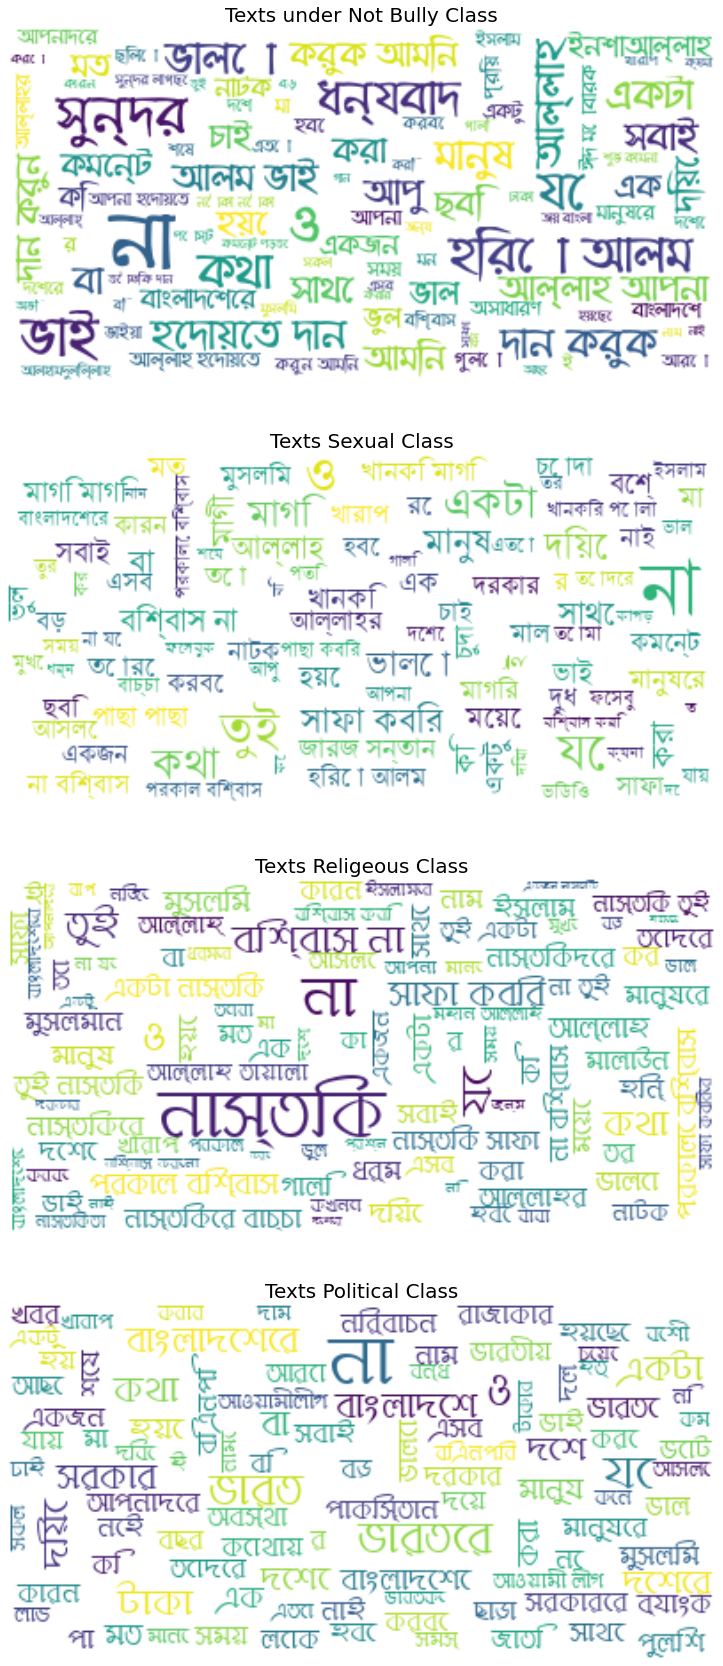

In [ ]:
#wordcloud to see importance of word for each label

regex = r"[\u0980-\u09FF]+"

# Start with one review:
df_NB = df[df['label']=="not bully"]
df_SE = df[df['label']=="sexual"]
df_RE = df[df['label']=="religious"]
df_TH = df[df['label']=="Political"]

text_NB = " ".join(review for review in df_NB.text)
text_SE = " ".join(review for review in df_SE.text)
text_RE = " ".join(review for review in df_RE.text)
text_TH = " ".join(review for review in df_TH.text)

fig, ax = plt.subplots(4, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_NB = WordCloud(font_path="/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/fonts/BenSenHandwriting.ttf",max_font_size=50,max_words=100,regexp=regex, background_color="white").generate(text_NB).to_file("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/wordcloud/not bully texts.png")
wordcloud_SE = WordCloud(font_path="/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/fonts/NikoshLight.ttf",max_font_size=50,max_words=100,regexp=regex, background_color="white").generate(text_SE).to_file("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/wordcloud/sexual texts.png")
wordcloud_RE = WordCloud(font_path="/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/fonts/MOHAO___.ttf",max_font_size=50,max_words=100,regexp=regex, background_color="white").generate(text_RE).to_file("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/wordcloud/religeous texts.png")
wordcloud_TH = WordCloud(font_path="/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/fonts/MOHAO___.ttf",max_font_size=50,max_words=100,regexp=regex, background_color="white").generate(text_TH).to_file("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/wordcloud/threat texts.png")


# Display the generated image:
ax[0].imshow(wordcloud_NB, interpolation='bilinear')
ax[0].set_title('Texts under Not Bully Class',fontsize=20)
ax[0].axis('off')

ax[1].imshow(wordcloud_SE, interpolation='bilinear')
ax[1].set_title('Texts Sexual Class',fontsize=20)
ax[1].axis('off')

ax[2].imshow(wordcloud_RE, interpolation='bilinear')
ax[2].set_title('Texts Religeous Class',fontsize=20)
ax[2].axis('off')

ax[3].imshow(wordcloud_TH, interpolation='bilinear')
ax[3].set_title('Texts Political Class',fontsize=20)
ax[3].axis('off')

In [ ]:
df["clean_text"]=df["text"]

In [ ]:
df.head()
df.head(0)

,comment,label,text,clean_text
0,ছালা পাকিস্তানীদের জন্য বাশ দিয়া দাও ভর দিয়া হ...,Political,ছালা পাকিস্তানীদের বাশ দিয়া দাও ভর দিয়া হাটবো ...,ছালা পাকিস্তানীদের বাশ দিয়া দাও ভর দিয়া হাটবো ...
1,"ফ্যামিলিটাই তো নাস্তিক,,,এর থকে বেশি আশা করা য...",religious,ফ্যামিলিটাই নাস্তিক থকে আশা করা যায় না ফাউল,ফ্যামিলিটাই নাস্তিক থকে আশা করা যায় না ফাউল
2,তুই মাগি তোর কোন মাফ নাই তুই বলে আখিরাত বিশ্বা...,sexual,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...
3,"সাফা কবির , আমি তোর ১জন কঠিনফ্যান ছিলাম। আজ থে...",religious,সাফা কবির কঠিনফ্ ছিলাম তো চরমঘৃনা করি তুই নাস্...,সাফা কবির কঠিনফ্ ছিলাম তো চরমঘৃনা করি তুই নাস্...
4,সুপার সুপার হিরো,not bully,সুপার সুপার হিরো,সুপার সুপার হিরো


In [ ]:
def stemming_text(corpus):
    stm = BanglaStemmer()
    return [' '.join([stm.stem(word) for word in review.split()]) for review in corpus]

df['text'] = stemming_text(df['text'])

Streaming output truncated to the last 5000 lines.
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
ap

In [ ]:
df.head()

,comment,label,text,clean_text
0,ছালা পাকিস্তানীদের জন্য বাশ দিয়া দাও ভর দিয়া হ...,Political,ছালা পাকিস্তানী বাশ দিয়া দাও ভর দিয়া হাটবো অভা...,ছালা পাকিস্তানীদের বাশ দিয়া দাও ভর দিয়া হাটবো ...
1,"ফ্যামিলিটাই তো নাস্তিক,,,এর থকে বেশি আশা করা য...",religious,ফ্যামিলিটা নাস্তিক থক আশা কর যায় না ফাউল,ফ্যামিলিটাই নাস্তিক থকে আশা করা যায় না ফাউল
2,তুই মাগি তোর কোন মাফ নাই তুই বলে আখিরাত বিশ্বা...,sexual,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...
3,"সাফা কবির , আমি তোর ১জন কঠিনফ্যান ছিলাম। আজ থে...",religious,সাফা কবির কঠিনফ্ ছিল তো চরমঘৃনা করি তুই নাস্তি...,সাফা কবির কঠিনফ্ ছিলাম তো চরমঘৃনা করি তুই নাস্...
4,সুপার সুপার হিরো,not bully,সুপ সুপ হিরো,সুপার সুপার হিরো


In [ ]:
#Tokenization

b_token = BasicTokenizer()
df['tokenized_clean_text'] = df.apply(lambda row: b_token.tokenize(row['clean_text']), axis=1)
df['tokenized_stem_text'] = df.apply(lambda row: b_token.tokenize(row['text']), axis=1)

df['token_length'] = df.apply(lambda row: len(row['tokenized_clean_text']), axis=1)

df.head() 

,comment,label,text,clean_text,tokenized_clean_text,tokenized_stem_text,token_length
0,ছালা পাকিস্তানীদের জন্য বাশ দিয়া দাও ভর দিয়া হ...,Political,ছালা পাকিস্তানী বাশ দিয়া দাও ভর দিয়া হাটবো অভা...,ছালা পাকিস্তানীদের বাশ দিয়া দাও ভর দিয়া হাটবো ...,"[ছালা, পাকিস্তানীদের, বাশ, দিয়া, দাও, ভর, দিয়া...","[ছালা, পাকিস্তানী, বাশ, দিয়া, দাও, ভর, দিয়া, হ...",13
1,"ফ্যামিলিটাই তো নাস্তিক,,,এর থকে বেশি আশা করা য...",religious,ফ্যামিলিটা নাস্তিক থক আশা কর যায় না ফাউল,ফ্যামিলিটাই নাস্তিক থকে আশা করা যায় না ফাউল,"[ফ্যামিলিটাই, নাস্তিক, থকে, আশা, করা, যায়, না,...","[ফ্যামিলিটা, নাস্তিক, থক, আশা, কর, যায়, না, ফাউল]",8
2,তুই মাগি তোর কোন মাফ নাই তুই বলে আখিরাত বিশ্বা...,sexual,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,"[তুই, মাগি, মাফ, তুই, আখিরাত, বিশ্বাস, করস, না...","[তুই, মাগি, মাফ, তুই, আখিরাত, বিশ্বাস, করস, না...",19
3,"সাফা কবির , আমি তোর ১জন কঠিনফ্যান ছিলাম। আজ থে...",religious,সাফা কবির কঠিনফ্ ছিল তো চরমঘৃনা করি তুই নাস্তি...,সাফা কবির কঠিনফ্ ছিলাম তো চরমঘৃনা করি তুই নাস্...,"[সাফা, কবির, কঠিনফ্, ছিলাম, তো, চরমঘৃনা, করি, ...","[সাফা, কবির, কঠিনফ্, ছিল, তো, চরমঘৃনা, করি, তু...",14
4,সুপার সুপার হিরো,not bully,সুপ সুপ হিরো,সুপার সুপার হিরো,"[সুপার, সুপার, হিরো]","[সুপ, সুপ, হিরো]",3


In [ ]:
df.describe()

,token_length
count,42036.00000
mean,13.48920
std,16.22168
min,0.00000
25%,5.00000
50%,8.00000
75%,15.00000
max,217.00000


In [ ]:
df.head()

,comment,label,text,clean_text,tokenized_clean_text,tokenized_stem_text,token_length
0,ছালা পাকিস্তানীদের জন্য বাশ দিয়া দাও ভর দিয়া হ...,Political,ছালা পাকিস্তানী বাশ দিয়া দাও ভর দিয়া হাটবো অভা...,ছালা পাকিস্তানীদের বাশ দিয়া দাও ভর দিয়া হাটবো ...,"[ছালা, পাকিস্তানীদের, বাশ, দিয়া, দাও, ভর, দিয়া...","[ছালা, পাকিস্তানী, বাশ, দিয়া, দাও, ভর, দিয়া, হ...",13
1,"ফ্যামিলিটাই তো নাস্তিক,,,এর থকে বেশি আশা করা য...",religious,ফ্যামিলিটা নাস্তিক থক আশা কর যায় না ফাউল,ফ্যামিলিটাই নাস্তিক থকে আশা করা যায় না ফাউল,"[ফ্যামিলিটাই, নাস্তিক, থকে, আশা, করা, যায়, না,...","[ফ্যামিলিটা, নাস্তিক, থক, আশা, কর, যায়, না, ফাউল]",8
2,তুই মাগি তোর কোন মাফ নাই তুই বলে আখিরাত বিশ্বা...,sexual,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,"[তুই, মাগি, মাফ, তুই, আখিরাত, বিশ্বাস, করস, না...","[তুই, মাগি, মাফ, তুই, আখিরাত, বিশ্বাস, করস, না...",19
3,"সাফা কবির , আমি তোর ১জন কঠিনফ্যান ছিলাম। আজ থে...",religious,সাফা কবির কঠিনফ্ ছিল তো চরমঘৃনা করি তুই নাস্তি...,সাফা কবির কঠিনফ্ ছিলাম তো চরমঘৃনা করি তুই নাস্...,"[সাফা, কবির, কঠিনফ্, ছিলাম, তো, চরমঘৃনা, করি, ...","[সাফা, কবির, কঠিনফ্, ছিল, তো, চরমঘৃনা, করি, তু...",14
4,সুপার সুপার হিরো,not bully,সুপ সুপ হিরো,সুপার সুপার হিরো,"[সুপার, সুপার, হিরো]","[সুপ, সুপ, হিরো]",3


In [ ]:
df1=df.copy()
col=['comment']
df=df.drop(col,axis=1)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/dataset/bangla_comments_tokenized.csv', index = False, header=True)
df.tail()

,label,text,clean_text,tokenized_clean_text,tokenized_stem_text,token_length
42031,religious,নাস্তিকএ কঠিন শায়েস্ কর দরক,নাস্তিকএদের কঠিন শায়েস্ করা দরকার,"[নাস্তিকএদের, কঠিন, শায়েস্, করা, দরকার]","[নাস্তিকএ, কঠিন, শায়েস্, কর, দরক]",5
42032,sexual,আয় না রে আয় না রে এক চোদা খা না রে,আয় না রে আয় না রে একটা চোদা খা না রে,"[আয়, না, রে, আয়, না, রে, একটা, চোদা, খা, না, রে]","[আয়, না, রে, আয়, না, রে, এক, চোদা, খা, না, রে]",11
42033,religious,কথা সত্য ভাই হিন্ ধর্ম বিশ্বাস র নাই,কথা সত্য ভাই হিন্ ধর্ম বিশ্বাস র নাই,"[কথা, সত্য, ভাই, হিন্, ধর্ম, বিশ্বাস, র, নাই]","[কথা, সত্য, ভাই, হিন্, ধর্ম, বিশ্বাস, র, নাই]",8
42034,religious,সালা মালাউন বাচ্চা তর্ক না লতা পা দিয়ে ঘের দিয়...,সালা মালাউনের বাচ্চা তর্ক না লতা পা দিয়ে ঘের দ...,"[সালা, মালাউনের, বাচ্চা, তর্ক, না, লতা, পা, দি...","[সালা, মালাউন, বাচ্চা, তর্ক, না, লতা, পা, দিয়ে...",21
42035,religious,কুও কথা কাফ,কুওার কথা কাফের,"[কুওার, কথা, কাফের]","[কুও, কথা, কাফ]",3


In [ ]:
from bnlp import POS
df.tokenized_clean_text = df.tokenized_clean_text.astype(str)
def pos_tagging(doc):
  bn_pos = POS()
  model_path = "/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/bn_pos.pkl"
  doc = bn_pos.tag(model_path,doc)
  return doc

In [ ]:
def get_postags(row):
    postags = pos_tagging(row["tokenized_clean_text"])
    list_classes = list()
    for  word in postags:
        list_classes.append(word[1])
    return list_classes

df["postags_list"] = df.apply(lambda row: get_postags(row), axis = 1)
df['postags_list'] = df.postags_list.apply(lambda x: [i for i in x if i != 'PU'])
df['postags_list'] = df.postags_list.apply(lambda x: [i for i in x if i != 'RDS'])
df.sample(10, random_state = 4)

,label,text,clean_text,tokenized_clean_text,tokenized_stem_text,token_length,postags_list
33306,Political,সত্য কথা বল কারণে আপনা আওয়ামীলীগ রাজা বললে কর স্য,সত্য কথা বলার কারণে আপনা আওয়ামীলীগ রাজাকার বল...,"['সত্য', 'কথা', 'বলার', 'কারণে', 'আপনা', 'আওয়া...","[সত্য, কথা, বল, কারণে, আপনা, আওয়ামীলীগ, রাজা, ...",10,"[NC, NC, NV, NC, NC, NC, NC, VM, NV, NC]"
26398,sexual,চুমাচুমি পোলাপাইন রাত তামাশা দিবে,চুমাচুমি পোলাপাইন রাতে তামাশা দিবে,"['চুমাচুমি', 'পোলাপাইন', 'রাতে', 'তামাশা', 'দি...","[চুমাচুমি, পোলাপাইন, রাত, তামাশা, দিবে]",5,"[NC, NC, NC, NP, VM]"
27229,not bully,সেই,সেই,['সেই'],[সেই],1,[DAB]
6514,sexual,crush গালি দেয় উদ্দেশ খানকি গালি থামা না,crush গালি দিচ্ছেন উদ্দেশ খানকি গালি থামাবেন না,"['crush', 'গালি', 'দিচ্ছেন', 'উদ্দেশ', 'খানকি'...","[crush, গালি, দেয়, উদ্দেশ, খানকি, গালি, থামা, না]",8,"[NP, NC, VM, NC, NP, NC, VM, CX]"
19977,not bully,সময় হুয়াওয় এড না করলে পারতেন,সময়ের হুয়াওয়ের এড না করলেও পারতেন,"['সময়ের', 'হুয়াওয়ের', 'এড', 'না', 'করলেও', 'পা...","[সময়, হুয়াওয়, এড, না, করলে, পারতেন]",6,"[NC, NP, NP, CX, LC, VM]"
25250,religious,মিডিয়া জগ একটুখানি সেলিব্রি হয় অহংকারে পা মাটি...,মিডিয়া জগতে একটুখানি সেলিব্রি হয়ে অহংকারে পা ম...,"['মিডিয়া', 'জগতে', 'একটুখানি', 'সেলিব্রি', 'হয়...","[মিডিয়া, জগ, একটুখানি, সেলিব্রি, হয়, অহংকারে, ...",22,"[NP, NC, JQ, NP, VM, NC, NC, NC, VM, CX, CX, P..."
19376,sexual,খাং মাগি বেশ্ চোদা—সেফুদা,খাং মাগি বেশ্ চোদা—সেফুদা,"['খাং', 'মাগি', 'বেশ্', 'চোদা', '—', 'সেফুদা']","[খাং, মাগি, বেশ্, চোদা, —, সেফুদা]",6,"[NP, NP, NP, NP, NP, NP]"
33344,not bully,আচ্ছা রিপোর্ সাহেব কাল সাফা কবীর বিতর্কিত মন্ত...,আচ্ছা রিপোর্টার সাহেব কাল সাফা কবীর বিতর্কিত ম...,"['আচ্ছা', 'রিপোর্টার', 'সাহেব', 'কাল', 'সাফা',...","[আচ্ছা, রিপোর্, সাহেব, কাল, সাফা, কবীর, বিতর্ক...",14,"[CIN, NC, NP, ALC, NC, NP, JJ, NC, VM, ALC, NP..."
25319,sexual,আপুরে হট হট লাগত,আপুরে হট হট লাগতেছে,"['আপুরে', 'হট', 'হট', 'লাগতেছে']","[আপুরে, হট, হট, লাগত]",4,"[NP, NP, NP, VM]"
21573,religious,সাফা কবির পরকালে বিশ্বাস না বলতেছেন “ নাস্তিক ...,সাফা কবির পরকালে বিশ্বাস না বলতেছেন “ নাস্তিকে...,"['সাফা', 'কবির', 'পরকালে', 'বিশ্বাস', 'না', 'ব...","[সাফা, কবির, পরকালে, বিশ্বাস, না, বলতেছেন, “, ...",30,"[NC, NC, NC, NP, CX, VM, NP, NC, NC, VM, PPR, ..."


In [ ]:
df.shape

(42036, 7)

In [ ]:
from collections import Counter
from functools import reduce

def find_no_class(count, class_name = ""):
    total = 0
    for key in count.keys():
      if key.startswith(class_name):
        total += count[key]        
    return total


def get_classes(row, grammatical_class = ""):
    count = Counter(row["postags_list"])
    try:
      return find_no_class(count, class_name = grammatical_class)/len(row["postags_list"])
    except ZeroDivisionError:
      return find_no_class(count, class_name = grammatical_class)
    

df["freqAdverbs"] = df.apply(lambda row: get_classes(row, "AMN"), axis = 1)
df["freqPreposition"] = df.apply(lambda row: get_classes(row, "PP"), axis = 1)
df["freqPronoun"] = df.apply(lambda row: get_classes(row, "PPR"), axis = 1)
df["freqVerbs"] = df.apply(lambda row: get_classes(row, "VM"), axis = 1)
df["freqAdjectives"] = df.apply(lambda row: get_classes(row, "JJ"), axis = 1)
df["freqNouns"] = df.apply(lambda row: get_classes(row, ("NC")), axis = 1)
df["freqEnglish"] = df.apply(lambda row: get_classes(row, ("RDF")), axis = 1)


In [ ]:
df.tail()

,label,text,clean_text,tokenized_clean_text,tokenized_stem_text,token_length,postags_list,freqAdverbs,freqPreposition,freqPronoun,freqVerbs,freqAdjectives,freqNouns,freqEnglish
42031,religious,নাস্তিকএ কঠিন শায়েস্ কর দরক,নাস্তিকএদের কঠিন শায়েস্ করা দরকার,"['নাস্তিকএদের', 'কঠিন', 'শায়েস্', 'করা', 'দরকার']","[নাস্তিকএ, কঠিন, শায়েস্, কর, দরক]",5,"[NC, JJ, NP, NV, NC]",0.000000,0.000000,0.000000,0.000000,0.2,0.400000,0.0
42032,sexual,আয় না রে আয় না রে এক চোদা খা না রে,আয় না রে আয় না রে একটা চোদা খা না রে,"['আয়', 'না', 'রে', 'আয়', 'না', 'রে', 'একটা', '...","[আয়, না, রে, আয়, না, রে, এক, চোদা, খা, না, রে]",11,"[NC, CX, CIN, NC, CX, CIN, JQ, NP, NP, CX, CIN]",0.000000,0.000000,0.000000,0.000000,0.0,0.181818,0.0
42033,religious,কথা সত্য ভাই হিন্ ধর্ম বিশ্বাস র নাই,কথা সত্য ভাই হিন্ ধর্ম বিশ্বাস র নাই,"['কথা', 'সত্য', 'ভাই', 'হিন্', 'ধর্ম', 'বিশ্বা...","[কথা, সত্য, ভাই, হিন্, ধর্ম, বিশ্বাস, র, নাই]",8,"[NC, NC, NC, NP, NC, NP, NP, CX]",0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.0
42034,religious,সালা মালাউন বাচ্চা তর্ক না লতা পা দিয়ে ঘের দিয়...,সালা মালাউনের বাচ্চা তর্ক না লতা পা দিয়ে ঘের দ...,"['সালা', 'মালাউনের', 'বাচ্চা', 'তর্ক', 'না', '...","[সালা, মালাউন, বাচ্চা, তর্ক, না, লতা, পা, দিয়ে...",21,"[NC, NC, NC, NC, CX, NC, NC, PP, NC, PP, NP, N...",0.047619,0.142857,0.047619,0.047619,0.0,0.666667,0.0
42035,religious,কুও কথা কাফ,কুওার কথা কাফের,"['কুওার', 'কথা', 'কাফের']","[কুও, কথা, কাফ]",3,"[NP, NC, NC]",0.000000,0.000000,0.000000,0.000000,0.0,0.666667,0.0


In [ ]:
df.head()

,label,text,clean_text,tokenized_clean_text,tokenized_stem_text,token_length,postags_list,freqAdverbs,freqPreposition,freqPronoun,freqVerbs,freqAdjectives,freqNouns,freqEnglish
0,Political,ছালা পাকিস্তানী বাশ দিয়া দাও ভর দিয়া হাটবো অভা...,ছালা পাকিস্তানীদের বাশ দিয়া দাও ভর দিয়া হাটবো ...,"['ছালা', 'পাকিস্তানীদের', 'বাশ', 'দিয়া', 'দাও'...","[ছালা, পাকিস্তানী, বাশ, দিয়া, দাও, ভর, দিয়া, হ...",13,"[NC, NP, NC, VM, NC, NC, VM, VM, AMN, NP, NC, ...",0.076923,0.000000,0.000000,0.230769,0.000000,0.461538,0.0
1,religious,ফ্যামিলিটা নাস্তিক থক আশা কর যায় না ফাউল,ফ্যামিলিটাই নাস্তিক থকে আশা করা যায় না ফাউল,"['ফ্যামিলিটাই', 'নাস্তিক', 'থকে', 'আশা', 'করা'...","[ফ্যামিলিটা, নাস্তিক, থক, আশা, কর, যায়, না, ফাউল]",8,"[NC, JJ, VM, NC, NV, VM, CX, NP]",0.000000,0.000000,0.000000,0.250000,0.125000,0.250000,0.0
2,sexual,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,তুই মাগি মাফ তুই আখিরাত বিশ্বাস করস না তুই বাপ...,"['তুই', 'মাগি', 'মাফ', 'তুই', 'আখিরাত', 'বিশ্ব...","[তুই, মাগি, মাফ, তুই, আখিরাত, বিশ্বাস, করস, না...",19,"[PPR, NP, NC, PPR, NC, NP, NP, CX, PPR, NC, NC...",0.000000,0.210526,0.210526,0.052632,0.000000,0.368421,0.0
3,religious,সাফা কবির কঠিনফ্ ছিল তো চরমঘৃনা করি তুই নাস্তি...,সাফা কবির কঠিনফ্ ছিলাম তো চরমঘৃনা করি তুই নাস্...,"['সাফা', 'কবির', 'কঠিনফ্', 'ছিলাম', 'তো', 'চরম...","[সাফা, কবির, কঠিনফ্, ছিল, তো, চরমঘৃনা, করি, তু...",14,"[NC, NC, NP, VM, CX, NC, VM, PPR, JJ, NC, NP, ...",0.000000,0.071429,0.071429,0.214286,0.071429,0.357143,0.0
4,not bully,সুপ সুপ হিরো,সুপার সুপার হিরো,"['সুপার', 'সুপার', 'হিরো']","[সুপ, সুপ, হিরো]",3,"[NP, NP, NP]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/dataset/w_post_tag_bangla_comments_tokenized.csv', index = False, header=True)

In [ ]:
#df1=df[df['tokenized_clean_text'].map(len) < 40]

In [ ]:

df.shape

(42036, 14)

**Data Description and Visualization**

In [ ]:
print("shape of data",df.shape)
print("Number of rows: "+str(df.shape[0]))
print("Number of columns: "+str(df.shape[1]))

shape of data (42036, 14)
Number of rows: 42036
Number of columns: 14


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
token_length,42036.0,13.489200,16.221680,0.0,5.000000,8.000000,15.000000,217.000000
freqAdverbs,42036.0,0.002822,0.022779,0.0,0.000000,0.000000,0.000000,1.000000
freqPreposition,42036.0,0.030087,0.067009,0.0,0.000000,0.000000,0.030303,1.000000
freqPronoun,42036.0,0.019322,0.057405,0.0,0.000000,0.000000,0.000000,1.000000
freqVerbs,42036.0,0.144501,0.139510,0.0,0.000000,0.130435,0.214286,1.000000
freqAdjectives,42036.0,0.063792,0.112631,0.0,0.000000,0.000000,0.096774,1.000000
freqNouns,42036.0,0.344122,0.202492,0.0,0.222222,0.333333,0.472222,1.000000
freqEnglish,42036.0,0.003923,0.034041,0.0,0.000000,0.000000,0.000000,0.833333


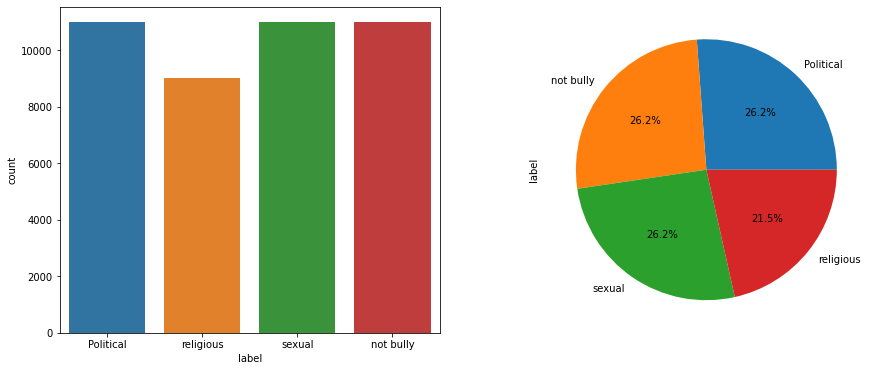

In [ ]:
#countplot and piechart for label column
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='label', data=df, ax=ax[0])
_ = df['label'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

plt.savefig("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/count plot and pie chart/label count plot and pie chart.png")

From the figure above we can see we got a small count of threat label so we need balance it with other classes and remove imbalancing from our dataframe.

In [ ]:
#parcentagewise null values
def missing_data_table(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data_table(df)

,Total,Percent
freqEnglish,0,0.0
freqNouns,0,0.0
freqAdjectives,0,0.0
freqVerbs,0,0.0
freqPronoun,0,0.0
freqPreposition,0,0.0
freqAdverbs,0,0.0
postags_list,0,0.0
token_length,0,0.0
tokenized_stem_text,0,0.0


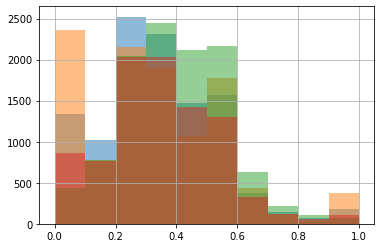

In [ ]:
df.loc[df["label"] == 'sexual', "freqNouns"].hist(alpha = 0.5);
df.loc[df["label"] == 'not bully', "freqNouns"].hist(alpha = 0.5);
df.loc[df["label"] == 'Political', "freqNouns"].hist(alpha = 0.5);
df.loc[df["label"] == 'religious', "freqNouns"].hist(alpha = 0.5);

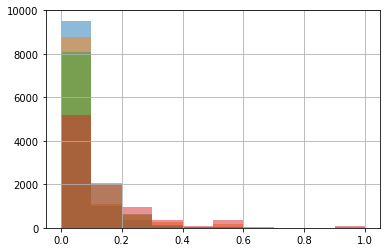

In [ ]:
df.loc[df["label"] == 'sexual', "freqAdjectives"].hist(alpha = 0.5);
df.loc[df["label"] == 'not bully', "freqAdjectives"].hist(alpha = 0.5);
df.loc[df["label"] == 'Political', "freqAdjectives"].hist(alpha = 0.5);
df.loc[df["label"] == 'religious', "freqAdjectives"].hist(alpha = 0.5);

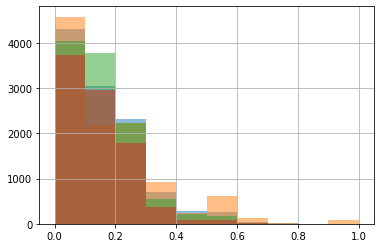

In [ ]:

df.loc[df["label"] == 'sexual', "freqVerbs"].hist(alpha = 0.5);
df.loc[df["label"] == 'not bully', "freqVerbs"].hist(alpha = 0.5);
df.loc[df["label"] == 'Political', "freqVerbs"].hist(alpha = 0.5);
df.loc[df["label"] == 'religious', "freqVerbs"].hist(alpha = 0.5);